In [2]:
#dependencies
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [3]:
filter_size1 = 5
num_filters1 = 16

filter_size2 = 5
num_filters2 = 36

fc_size = 128

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot = True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [15]:
data.test.cls = np.argmax(data.test.labels, 1)

In [7]:
img_size=28
img_flat_size = img_size*img_size
img_shape = (img_size,img_size)
num_channels = 1
num_classes = 10

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

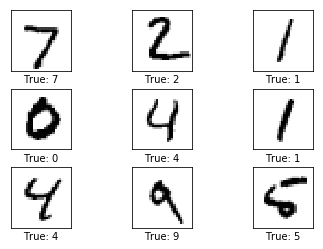

In [9]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [10]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev = 0.05))

In [11]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [13]:
def new_conv_layer(input,
                  num_input_channels,
                  filter_size,
                  num_filters,
                  use_pooling = True):

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape = shape)
    biases = new_biases(length = num_filters)

    layer = tf.nn.conv2d(input = input,
                        filter = weights,
                        strides = [1,1,1,1],
                        padding = 'SAME')

    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value = layer,
                              ksize = [1,2,2,1],
                              strides = [1,2,2,1],
                              padding = 'SAME')
        
    layer = tf.nn.relu(layer)
    return layer, weights

In [14]:
def flatten_layer(layer):
    
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1,num_features])
    return layer_flat, num_features

In [20]:
def new_fc_layer(input,
                num_inputs,
                num_outputs,
                use_relu = True):
    
    weights = new_weights(shape = [num_inputs, num_outputs])
    biases = new_biases(length = num_outputs)
    
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [17]:
x = tf.placeholder(tf.float32, shape = [None, img_flat_size], name = "x")

In [18]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [19]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

In [21]:
y_true_cls = tf.argmax(y_true, dimension=1)

In [22]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [23]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [24]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [25]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [26]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [27]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [28]:
num_features

1764

In [29]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [30]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [31]:
y_pred = tf.nn.softmax(layer_fc2)

In [32]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [33]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

In [34]:
cost = tf.reduce_mean(cross_entropy)

In [35]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [36]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [37]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [38]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [39]:
train_batch_size = 64

In [47]:
total_iters = 0

def optimize(num_iters):
    global total_iters
    start_time = time.time()
    
    for i in range(total_iters, total_iters+num_iters):
        
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {x: x_batch, y_true:y_true_batch}
        
        session.run(optimizer, feed_dict = feed_dict_train)
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iters += num_iters

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
        

In [48]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [49]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [50]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred = cls_pred)

In [51]:
print_test_accuracy()

Accuracy on Test-Set: 16.2% (1624 / 10000)


In [52]:
optimize(num_iters = 1)

Optimization Iteration:      1, Training Accuracy:  18.8%
Time usage: 0:00:00


In [53]:
optimize(num_iters = 1000)

Optimization Iteration:    101, Training Accuracy:  67.2%
Optimization Iteration:    201, Training Accuracy:  84.4%
Optimization Iteration:    301, Training Accuracy:  76.6%
Optimization Iteration:    401, Training Accuracy:  89.1%
Optimization Iteration:    501, Training Accuracy:  90.6%
Optimization Iteration:    601, Training Accuracy:  87.5%
Optimization Iteration:    701, Training Accuracy:  95.3%
Optimization Iteration:    801, Training Accuracy:  95.3%
Optimization Iteration:    901, Training Accuracy:  89.1%
Optimization Iteration:   1001, Training Accuracy:  93.8%
Time usage: 0:01:27


In [ ]:
optimize(num_iters = 100000)

Optimization Iteration:   1101, Training Accuracy:  93.8%
Optimization Iteration:   1201, Training Accuracy:  96.9%
Optimization Iteration:   1301, Training Accuracy:  96.9%
Optimization Iteration:   1401, Training Accuracy:  93.8%
Optimization Iteration:   1501, Training Accuracy:  95.3%
Optimization Iteration:   1601, Training Accuracy:  96.9%
Optimization Iteration:   1701, Training Accuracy:  96.9%
Optimization Iteration:   1801, Training Accuracy:  96.9%
Optimization Iteration:   1901, Training Accuracy: 100.0%
Optimization Iteration:   2001, Training Accuracy:  95.3%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy:  98.4%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy:  95.3%
Optimization Iteration:   2501, Training Accuracy:  96.9%
Optimization Iteration:   2601, Training Accuracy:  95.3%
Optimization Iteration:   2701, Training Accuracy:  98.4%
Optimization I